In [1]:
#IMPORTS
import numpy as np
import math

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

import geopandas as gpd
from geopandas import points_from_xy

import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats
#import osmnx as ox
import contextily as ctx

from sklearn import tree, model_selection, metrics
from sklearn.metrics import r2_score
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from math import pi


# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12
pd.set_option('display.max_columns', 500)

import statsmodels.api as sm

In [163]:
#load in data
crs = 'epsg:3310'
full_smc = gpd.read_file("/Volumes/Emmalina_external/CAPSTONE/Bay_Area/Final_Layers/SMC_FINAL_409.geojson", crs=crs)
full_smc.crs
smc = full_smc[full_smc['AAL_MEAN'] > 0]

## Visualizations

In [164]:
## fix SFO to be classified as public 
smc['MAJ_USE'] = smc['MAJ_USE'].astype('str')
smc.loc[smc['GEOID'] == '060819843001', 'MAJ_USE'] = 'Public'

In [165]:
## bring in outlines layer
outlines = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_state_500k.zip')
outlines = outlines[outlines['GEOID'] == '06']  # just CA
outlines = outlines.to_crs(crs)

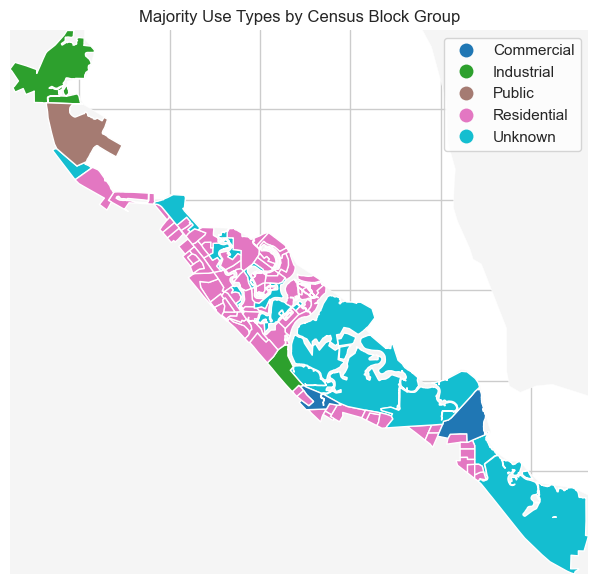

In [166]:
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors


#What majority Use Type is found per census block group?
#desired_order = ['Residential','Commercial', 'Industrial',  'Other', 'Vacant','Public', 'Unknown']
color_list = ['#2077B4', '#2DA02D', '#9468BD', '#A57B72', '#BCBD23', '#E377C2', '#14BED0']
rgba_colors = [mcolors.hex2color(hex_code) for hex_code in color_list]
custom_cmap = mcolors.ListedColormap(rgba_colors)

smc['MAJ_USE'] = smc['MAJ_USE'].astype('category')#.cat.reorder_categories(desired_order, ordered=True)

fig, ax = plt.subplots(figsize=(10, 6)) 
outlines.plot(ax=ax, facecolor='none', color='whitesmoke',linewidth=0.3)

smc[smc['annual_assessment_Total'] > 0].plot(column='MAJ_USE', legend=True, cmap=custom_cmap, ax=ax)
ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title('Majority Use Types by Census Block Group')

minx, miny, maxx, maxy = smc[smc['annual_assessment_Total'] > 0].total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.tight_layout()
plt.show()

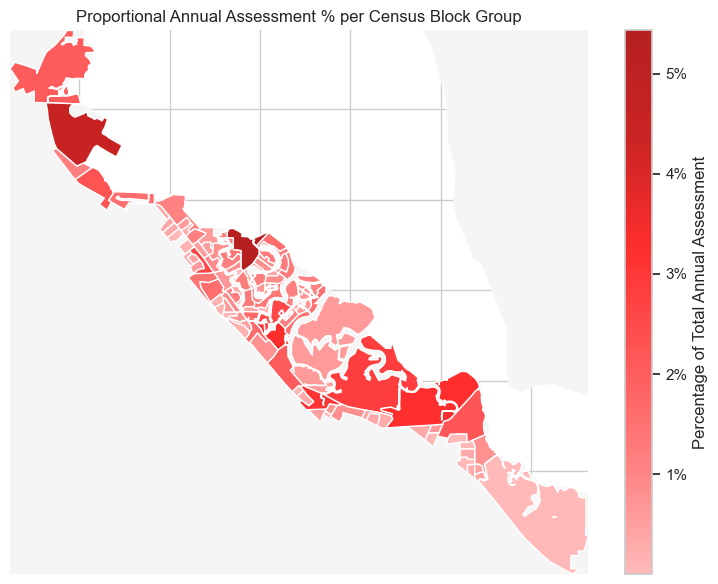

In [167]:
from matplotlib.colors import LinearSegmentedColormap

# Calculate the range of your data values
data_min = smc['annual_assessment_Total_proportion'].min()
data_max = smc['annual_assessment_Total_proportion'].max()

# List of hex color codes
hex_colors = ['#b62020', '#cb2424', '#fe2e2e', '#fe5757', '#fe8181','#ffb9b9']
hex_colors = hex_colors[::-1]

# Define positions for each color along the colormap
positions = np.linspace(0, 1, len(hex_colors))

# Create color dictionary with colors and positions
colors = [(pos, color) for pos, color in zip(positions, hex_colors)]

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

#who pays the most (proportional to total)
fig, ax = plt.subplots(figsize=(10, 6)) 
outlines.plot(ax=ax, facecolor='none', color='whitesmoke',linewidth=0.3)
smc[smc['annual_assessment_Total'] > 0].plot(column='annual_assessment_Total_proportion', cmap=custom_cmap, ax=ax)
ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
cbar = ax.figure.colorbar(ax.collections[1], ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Percentage of Total Annual Assessment')
ticks = cbar.ax.get_yticks()
cbar.ax.set_yticklabels(['{:.0f}%'.format(tick * 100) for tick in ticks])
ax.set_title('Proportional Annual Assessment % per Census Block Group')

minx, miny, maxx, maxy = smc[smc['annual_assessment_Total'] > 0].total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)


plt.tight_layout()
plt.show()


## Data Preprocessing

In [168]:
full_smc.head()

,OBJECTID,GEOID,NAME,TRACTID,socVuln70,socVuln90,ind_70pct,ind_90pct,socVulnRank,estimate_totPop,estimate_totHH,estimate_AveHHSize,estimate_renter,estimate_under5,estimate_noVeh,estimate_disabHH,estimate_SglPar,estimate_PoC,estimate_65Alone,estimate_noHS,estimate_MortgageHCB,estimate_LEP_HH,estimate_B200Pv,estimate_RentHCB,estimate_NoCtz,estimate_50MedianAMI,moe_totPop,moe_totHH,moe_AveHHSize,moe_renter,moe_under5,moe_noVeh,moe_disabHH,moe_SglPar,moe_PoC,moe_65Alone,moe_noHS,moe_MortgageHCB,moe_LEP_HH,moe_B200Pv,moe_RentHCB,moe_NoCtz,moe_50MedianAMI,pct_renter,pct_under5,pct_noVeh,pct_disabHH,pct_SglPar,pct_PoC,pct_65Alone,pct_noHS,pct_MortgageHCB,pct_LEP_HH,pct_B200Pv,pct_RentHCB,pct_NoCtz,pct_50MedianAMI,pct_moe_renter,pct_moe_under5,pct_moe_noVeh,pct_moe_disabHH,pct_moe_SglPar,pct_moe_PoC,pct_moe_65Alone,pct_moe_noHS,pct_moe_MortgageHCB,pct_moe_LEP_HH,pct_moe_B200Pv,pct_moe_RentHCB,pct_moe_NoCtz,pct_moe_50MedianAMI,flag70_renter,flag70_under5,flag70_noVeh,flag70_disabHH,flag70_SglPar,flag70_PoC,flag70_65Alone,flag70_noHS,flag70_LEP_HH,flag70_NoCtz,flag70_HCB,flag70_VLowInc,flag90_renter,flag90_under5,flag90_noVeh,flag90_disabHH,flag90_SglPar,flag90_PoC,flag90_65Alone,flag90_noHS,flag90_LEP_HH,flag90_NoCtz,flag90_HCB,flag90_VLowInc,estimate_ForBrn,estimate_LEP_Spanish,estimate_LEP_Chinese,estimate_LEP_Vietnms,estimate_LEP_Tagalog,moe_ForBrn,moe_LEP_Spanish,moe_LEP_Chinese,moe_LEP_Vietnms,moe_LEP_Tagalog,pct_ForBrn,pct_LEP_Spanish,pct_LEP_Chinese,pct_LEP_Vietnms,pct_LEP_Tagalog,pct_moe_ForBrn,pct_moe_LEP_Spanish,pct_moe_LEP_Chinese,pct_moe_LEP_Vietnms,pct_moe_LEP_Tagalog,estimate_Latino,estimate_Black,estimate_AmIndn,estimate_Asian,estimate_Island,estimate_OthRac,estimate_TwoRac,estimate_Under10,estimate_Under18,moe_Latino,moe_Black,moe_AmIndn,moe_Asian,moe_Island,moe_OthRac,moe_TwoRac,moe_Under10,moe_Under18,pct_Latino,pct_Black,pct_AmIndn,pct_Asian,pct_Island,pct_OthRac,pct_TwoRac,pct_Under10,pct_Under18,pct_moe_Latino,pct_moe_Black,pct_moe_AmIndn,pct_moe_Asian,pct_moe_Island,pct_moe_OthRac,pct_moe_TwoRac,pct_moe_Under10,pct_moe_Under18,MTC_CoC_2018,displcType,CES4_pctl,Clean_pctl,GW_pctl,Haz_pct,IWB_pctl,Solid_pctl,PDA_Name,PDA_ID,contam70,contam90,contamVulnRank,contam_ind_70pct,contam_ind_90pct,centroid_lng,centroid_lat,SUM_res_units_2010_exp_12,SUM_res_units_2040_exp_12,SUM_job_spaces_2010_exp_12,SUM_job_spaces_2040_exp_12,SUM_res_units_2010_exp_24,SUM_res_units_2040_exp_24,SUM_job_spaces_2010_exp_24,SUM_job_spaces_2040_exp_24,SUM_res_units_2010_exp_36,SUM_res_units_2040_exp_36,SUM_job_spaces_2010_exp_36,SUM_job_spaces_2040_exp_36,SUM_res_units_2010_exp_48,SUM_res_units_2040_exp_48,SUM_job_spaces_2010_exp_48,SUM_job_spaces_2040_exp_48,SUM_res_units_2010_exp_52,SUM_res_units_2040_exp_52,SUM_job_spaces_2010_exp_52,SUM_job_spaces_2040_exp_52,SUM_res_units_2010_exp_66,SUM_res_units_2040_exp_66,SUM_job_spaces_2010_exp_66,SUM_job_spaces_2040_exp_66,SUM_res_units_2010_exp_77,SUM_res_units_2040_exp_77,SUM_job_spaces_2010_exp_77,SUM_job_spaces_2040_exp_77,SUM_res_units_2010_exp_84,SUM_res_units_2040_exp_84,SUM_job_spaces_2010_exp_84,SUM_job_spaces_2040_exp_84,SUM_res_units_2010_exp_96,SUM_res_units_2040_exp_96,SUM_job_spaces_2010_exp_96,SUM_job_spaces_2040_exp_96,SUM_res_units_2010_exp_108,SUM_res_units_2040_exp_108,SUM_job_spaces_2010_exp_108,SUM_job_spaces_2040_exp_108,SUM_res_units_2010_exp_FEMA100,SUM_res_units_2040_exp_FEMA100,SUM_job_spaces_2010_exp_FEMA100,SUM_job_spaces_2040_exp_FEMA100,SUM_res_units_2010_exp_FEMA500,SUM_res_units_2040_exp_FEMA500,SUM_job_spaces_2010_exp_FEMA500,SUM_job_spaces_2040_exp_FEMA500,SUM_res_units_2010_exp_SFPrecip,SUM_res_units_2040_exp_SFPrecip,SUM_job_spaces_2010_exp_SFPreci,SUM_job_spaces_2040_exp_SFPreci,SUM_total_residential_units_201,SUM_total_residential_units_204,SUM_total_job_spaces_2010_Total,SUM_total_job_spaces_2040_Total,socVulnRank2020,contamVulnRank2020,soc_diff_val,contam_diff_val,combined_vulnerability,Shape__Area,Shape__Length,SHAPE,FDP_mean,LAND_VALUE,IMPR_VALUE,TOT_VALUE,LO

In [169]:
smc[['GEOID','median_income','geometry']].sort_values(by='median_income', ascending=False).head(10)

,GEOID,median_income,geometry
511,060816085013,250001.0,"POLYGON ((-201377.022 -51220.498, -201951.131 ..."
306,060816103032,250001.0,"POLYGON ((-196576.881 -50331.151, -196616.991 ..."
188,060816080241,250001.0,"POLYGON ((-200677.908 -49270.448, -200627.044 ..."
506,060816081001,238424.0,"POLYGON ((-200039.123 -47941.048, -199770.811 ..."
154,060816101002,234167.0,"POLYGON ((-197587.622 -55549.434, -197960.412 ..."
481,060816080232,232083.0,"POLYGON ((-200465.853 -49915.029, -200424.290 ..."
97,060816075001,219318.0,"POLYGON ((-202302.460 -49385.645, -202006.561 ..."
482,060816086002,217656.0,"POLYGON ((-200102.924 -51504.161, -200103.550 ..."
90,060816103031,215078.0,"POLYGON ((-197433.275 -49831.055, -197148.744 ..."
295,060816080023,208194.0,"MULTIPOLYGON (((-200131.767 -50359.701, -20014..."


In [170]:
#put all pcts into an index 0-1

smc['pct_MortgageHCB'] = smc['pct_MortgageHCB'] / 100
smc['pct_65Alone'] = smc['pct_65Alone'] / 100
smc['pct_50MedianAMI'] = smc['pct_50MedianAMI'] / 100
smc['pct_Latino'] = smc['pct_Latino'] / 100
smc['pct_Black'] = smc['pct_Black'] / 100
smc['pct_White'] = smc['pct_White'] / 100
smc['pct_AmIndn'] = smc['pct_AmIndn'] / 100
smc['pct_Asian'] = smc['pct_Asian'] / 100
smc['pct_Island'] = smc['pct_Island'] / 100
smc['pct_OthRac'] = smc['pct_OthRac'] / 100
smc['pct_TwoRac'] = smc['pct_TwoRac'] / 100

In [171]:
# turn TOT_VALUE into rate

smc['AV_sqm'] = smc['TOT_VALUE'] / smc['area_sqm']

In [172]:
#examine exposed vs non-exposed parcels
full_smc.groupby('AAL_flg')[['TOT_VALUE','estimate_totHH','median_income','pct_MortgageHCB','pct_PoC','pct_50MedianAMI','pct_Latino','pct_Black','pct_White','pct_Asian','num_parcels','impact_Total']].agg({
    'TOT_VALUE':'sum',
    'estimate_totHH':'sum',
    'median_income':'median',
    'pct_MortgageHCB':'median',
    'pct_PoC':'median',
    'pct_50MedianAMI':'median',
    'pct_Latino':'median',
    'pct_Black':'median',
    'pct_White':'median',
    'pct_Asian':'median',
    'num_parcels':'sum',
    'impact_Total':'sum'
})

,TOT_VALUE,estimate_totHH,median_income,pct_MortgageHCB,pct_PoC,pct_50MedianAMI,pct_Latino,pct_Black,pct_White,pct_Asian,num_parcels,impact_Total
AAL_flg,,,,,,,,,,,,
0,2.046639e+11,220361,145584.0,13.815789,57.142857,18.959108,15.200517,0.266223,42.857143,24.461106,207716.0,3.0
1,8.091925e+10,55765,141885.0,11.853631,68.670335,18.524739,17.932280,1.466355,31.329665,30.080725,57435.0,19610.0


In [173]:
#make sure all percentages are in the same units

sub_smc = smc[['annual_assessment_Residential_proportion','total_resassess_persqm','pct_finuns','pct_owner','impact_Residential','pct_MortgageHCB','FDP_mean',
                 'pct_65Alone','pct_50MedianAMI', 'AV_sqm', 'pct_Latino', 'pct_Black', 'pct_White', 'pct_AmIndn', 
                 'pct_Asian', 'pct_Island','pct_OthRac','pct_TwoRac']]

for column in sub_smc.columns:
    nan_count = sub_smc[column].isna().sum()
    print(f"NaN count in column '{column}': {nan_count}")

NaN count in column 'annual_assessment_Residential_proportion': 1
NaN count in column 'total_resassess_persqm': 1
NaN count in column 'pct_finuns': 15
NaN count in column 'pct_owner': 1
NaN count in column 'impact_Residential': 1
NaN count in column 'pct_MortgageHCB': 1
NaN count in column 'FDP_mean': 0
NaN count in column 'pct_65Alone': 1
NaN count in column 'pct_50MedianAMI': 1
NaN count in column 'AV_sqm': 0
NaN count in column 'pct_Latino': 1
NaN count in column 'pct_Black': 1
NaN count in column 'pct_White': 1
NaN count in column 'pct_AmIndn': 1
NaN count in column 'pct_Asian': 1
NaN count in column 'pct_Island': 1
NaN count in column 'pct_OthRac': 1
NaN count in column 'pct_TwoRac': 1


In [174]:
smc[smc['impact_Residential'].isna()]

,OBJECTID,GEOID,NAME,TRACTID,socVuln70,socVuln90,ind_70pct,ind_90pct,socVulnRank,estimate_totPop,estimate_totHH,estimate_AveHHSize,estimate_renter,estimate_under5,estimate_noVeh,estimate_disabHH,estimate_SglPar,estimate_PoC,estimate_65Alone,estimate_noHS,estimate_MortgageHCB,estimate_LEP_HH,estimate_B200Pv,estimate_RentHCB,estimate_NoCtz,estimate_50MedianAMI,moe_totPop,moe_totHH,moe_AveHHSize,moe_renter,moe_under5,moe_noVeh,moe_disabHH,moe_SglPar,moe_PoC,moe_65Alone,moe_noHS,moe_MortgageHCB,moe_LEP_HH,moe_B200Pv,moe_RentHCB,moe_NoCtz,moe_50MedianAMI,pct_renter,pct_under5,pct_noVeh,pct_disabHH,pct_SglPar,pct_PoC,pct_65Alone,pct_noHS,pct_MortgageHCB,pct_LEP_HH,pct_B200Pv,pct_RentHCB,pct_NoCtz,pct_50MedianAMI,pct_moe_renter,pct_moe_under5,pct_moe_noVeh,pct_moe_disabHH,pct_moe_SglPar,pct_moe_PoC,pct_moe_65Alone,pct_moe_noHS,pct_moe_MortgageHCB,pct_moe_LEP_HH,pct_moe_B200Pv,pct_moe_RentHCB,pct_moe_NoCtz,pct_moe_50MedianAMI,flag70_renter,flag70_under5,flag70_noVeh,flag70_disabHH,flag70_SglPar,flag70_PoC,flag70_65Alone,flag70_noHS,flag70_LEP_HH,flag70_NoCtz,flag70_HCB,flag70_VLowInc,flag90_renter,flag90_under5,flag90_noVeh,flag90_disabHH,flag90_SglPar,flag90_PoC,flag90_65Alone,flag90_noHS,flag90_LEP_HH,flag90_NoCtz,flag90_HCB,flag90_VLowInc,estimate_ForBrn,estimate_LEP_Spanish,estimate_LEP_Chinese,estimate_LEP_Vietnms,estimate_LEP_Tagalog,moe_ForBrn,moe_LEP_Spanish,moe_LEP_Chinese,moe_LEP_Vietnms,moe_LEP_Tagalog,pct_ForBrn,pct_LEP_Spanish,pct_LEP_Chinese,pct_LEP_Vietnms,pct_LEP_Tagalog,pct_moe_ForBrn,pct_moe_LEP_Spanish,pct_moe_LEP_Chinese,pct_moe_LEP_Vietnms,pct_moe_LEP_Tagalog,estimate_Latino,estimate_Black,estimate_AmIndn,estimate_Asian,estimate_Island,estimate_OthRac,estimate_TwoRac,estimate_Under10,estimate_Under18,moe_Latino,moe_Black,moe_AmIndn,moe_Asian,moe_Island,moe_OthRac,moe_TwoRac,moe_Under10,moe_Under18,pct_Latino,pct_Black,pct_AmIndn,pct_Asian,pct_Island,pct_OthRac,pct_TwoRac,pct_Under10,pct_Under18,pct_moe_Latino,pct_moe_Black,pct_moe_AmIndn,pct_moe_Asian,pct_moe_Island,pct_moe_OthRac,pct_moe_TwoRac,pct_moe_Under10,pct_moe_Under18,MTC_CoC_2018,displcType,CES4_pctl,Clean_pctl,GW_pctl,Haz_pct,IWB_pctl,Solid_pctl,PDA_Name,PDA_ID,contam70,contam90,contamVulnRank,contam_ind_70pct,contam_ind_90pct,centroid_lng,centroid_lat,SUM_res_units_2010_exp_12,SUM_res_units_2040_exp_12,SUM_job_spaces_2010_exp_12,SUM_job_spaces_2040_exp_12,SUM_res_units_2010_exp_24,SUM_res_units_2040_exp_24,SUM_job_spaces_2010_exp_24,SUM_job_spaces_2040_exp_24,SUM_res_units_2010_exp_36,SUM_res_units_2040_exp_36,SUM_job_spaces_2010_exp_36,SUM_job_spaces_2040_exp_36,SUM_res_units_2010_exp_48,SUM_res_units_2040_exp_48,SUM_job_spaces_2010_exp_48,SUM_job_spaces_2040_exp_48,SUM_res_units_2010_exp_52,SUM_res_units_2040_exp_52,SUM_job_spaces_2010_exp_52,SUM_job_spaces_2040_exp_52,SUM_res_units_2010_exp_66,SUM_res_units_2040_exp_66,SUM_job_spaces_2010_exp_66,SUM_job_spaces_2040_exp_66,SUM_res_units_2010_exp_77,SUM_res_units_2040_exp_77,SUM_job_spaces_2010_exp_77,SUM_job_spaces_2040_exp_77,SUM_res_units_2010_exp_84,SUM_res_units_2040_exp_84,SUM_job_spaces_2010_exp_84,SUM_job_spaces_2040_exp_84,SUM_res_units_2010_exp_96,SUM_res_units_2040_exp_96,SUM_job_spaces_2010_exp_96,SUM_job_spaces_2040_exp_96,SUM_res_units_2010_exp_108,SUM_res_units_2040_exp_108,SUM_job_spaces_2010_exp_108,SUM_job_spaces_2040_exp_108,SUM_res_units_2010_exp_FEMA100,SUM_res_units_2040_exp_FEMA100,SUM_job_spaces_2010_exp_FEMA100,SUM_job_spaces_2040_exp_FEMA100,SUM_res_units_2010_exp_FEMA500,SUM_res_units_2040_exp_FEMA500,SUM_job_spaces_2010_exp_FEMA500,SUM_job_spaces_2040_exp_FEMA500,SUM_res_units_2010_exp_SFPrecip,SUM_res_units_2040_exp_SFPrecip,SUM_job_spaces_2010_exp_SFPreci,SUM_job_spaces_2040_exp_SFPreci,SUM_total_residential_units_201,SUM_total_residential_units_204,SUM_total_job_spaces_2010_Total,SUM_total_job_spaces_2040_Total,socVulnRank2020,contamVulnRank2020,soc_diff_val,contam_diff_val,combined_vulnerability,Shape__Area,Shape__Length,SHAPE,FDP_mean,LAND_VALUE,IMPR_VALUE,TOT_VALUE,LO

In [175]:
#drop NAN columns
smc.drop(index=513, inplace=True)


In [176]:
print(smc['pct_finuns'].describe())
print('median = ', np.nanmedian(smc['pct_finuns']))
print('mode = ',smc['pct_finuns'].mode())

count    84.000000
mean      0.366905
std       0.152939
min       0.070000
25%       0.247500
50%       0.360000
75%       0.470000
max       0.760000
Name: pct_finuns, dtype: float64
median =  0.36
mode =  0    0.31
1    0.39
Name: pct_finuns, dtype: float64


In [177]:
#fill nans with the mode
smc['pct_finuns_fill'] = smc['pct_finuns'].fillna(0.36)

## Investigate Variables

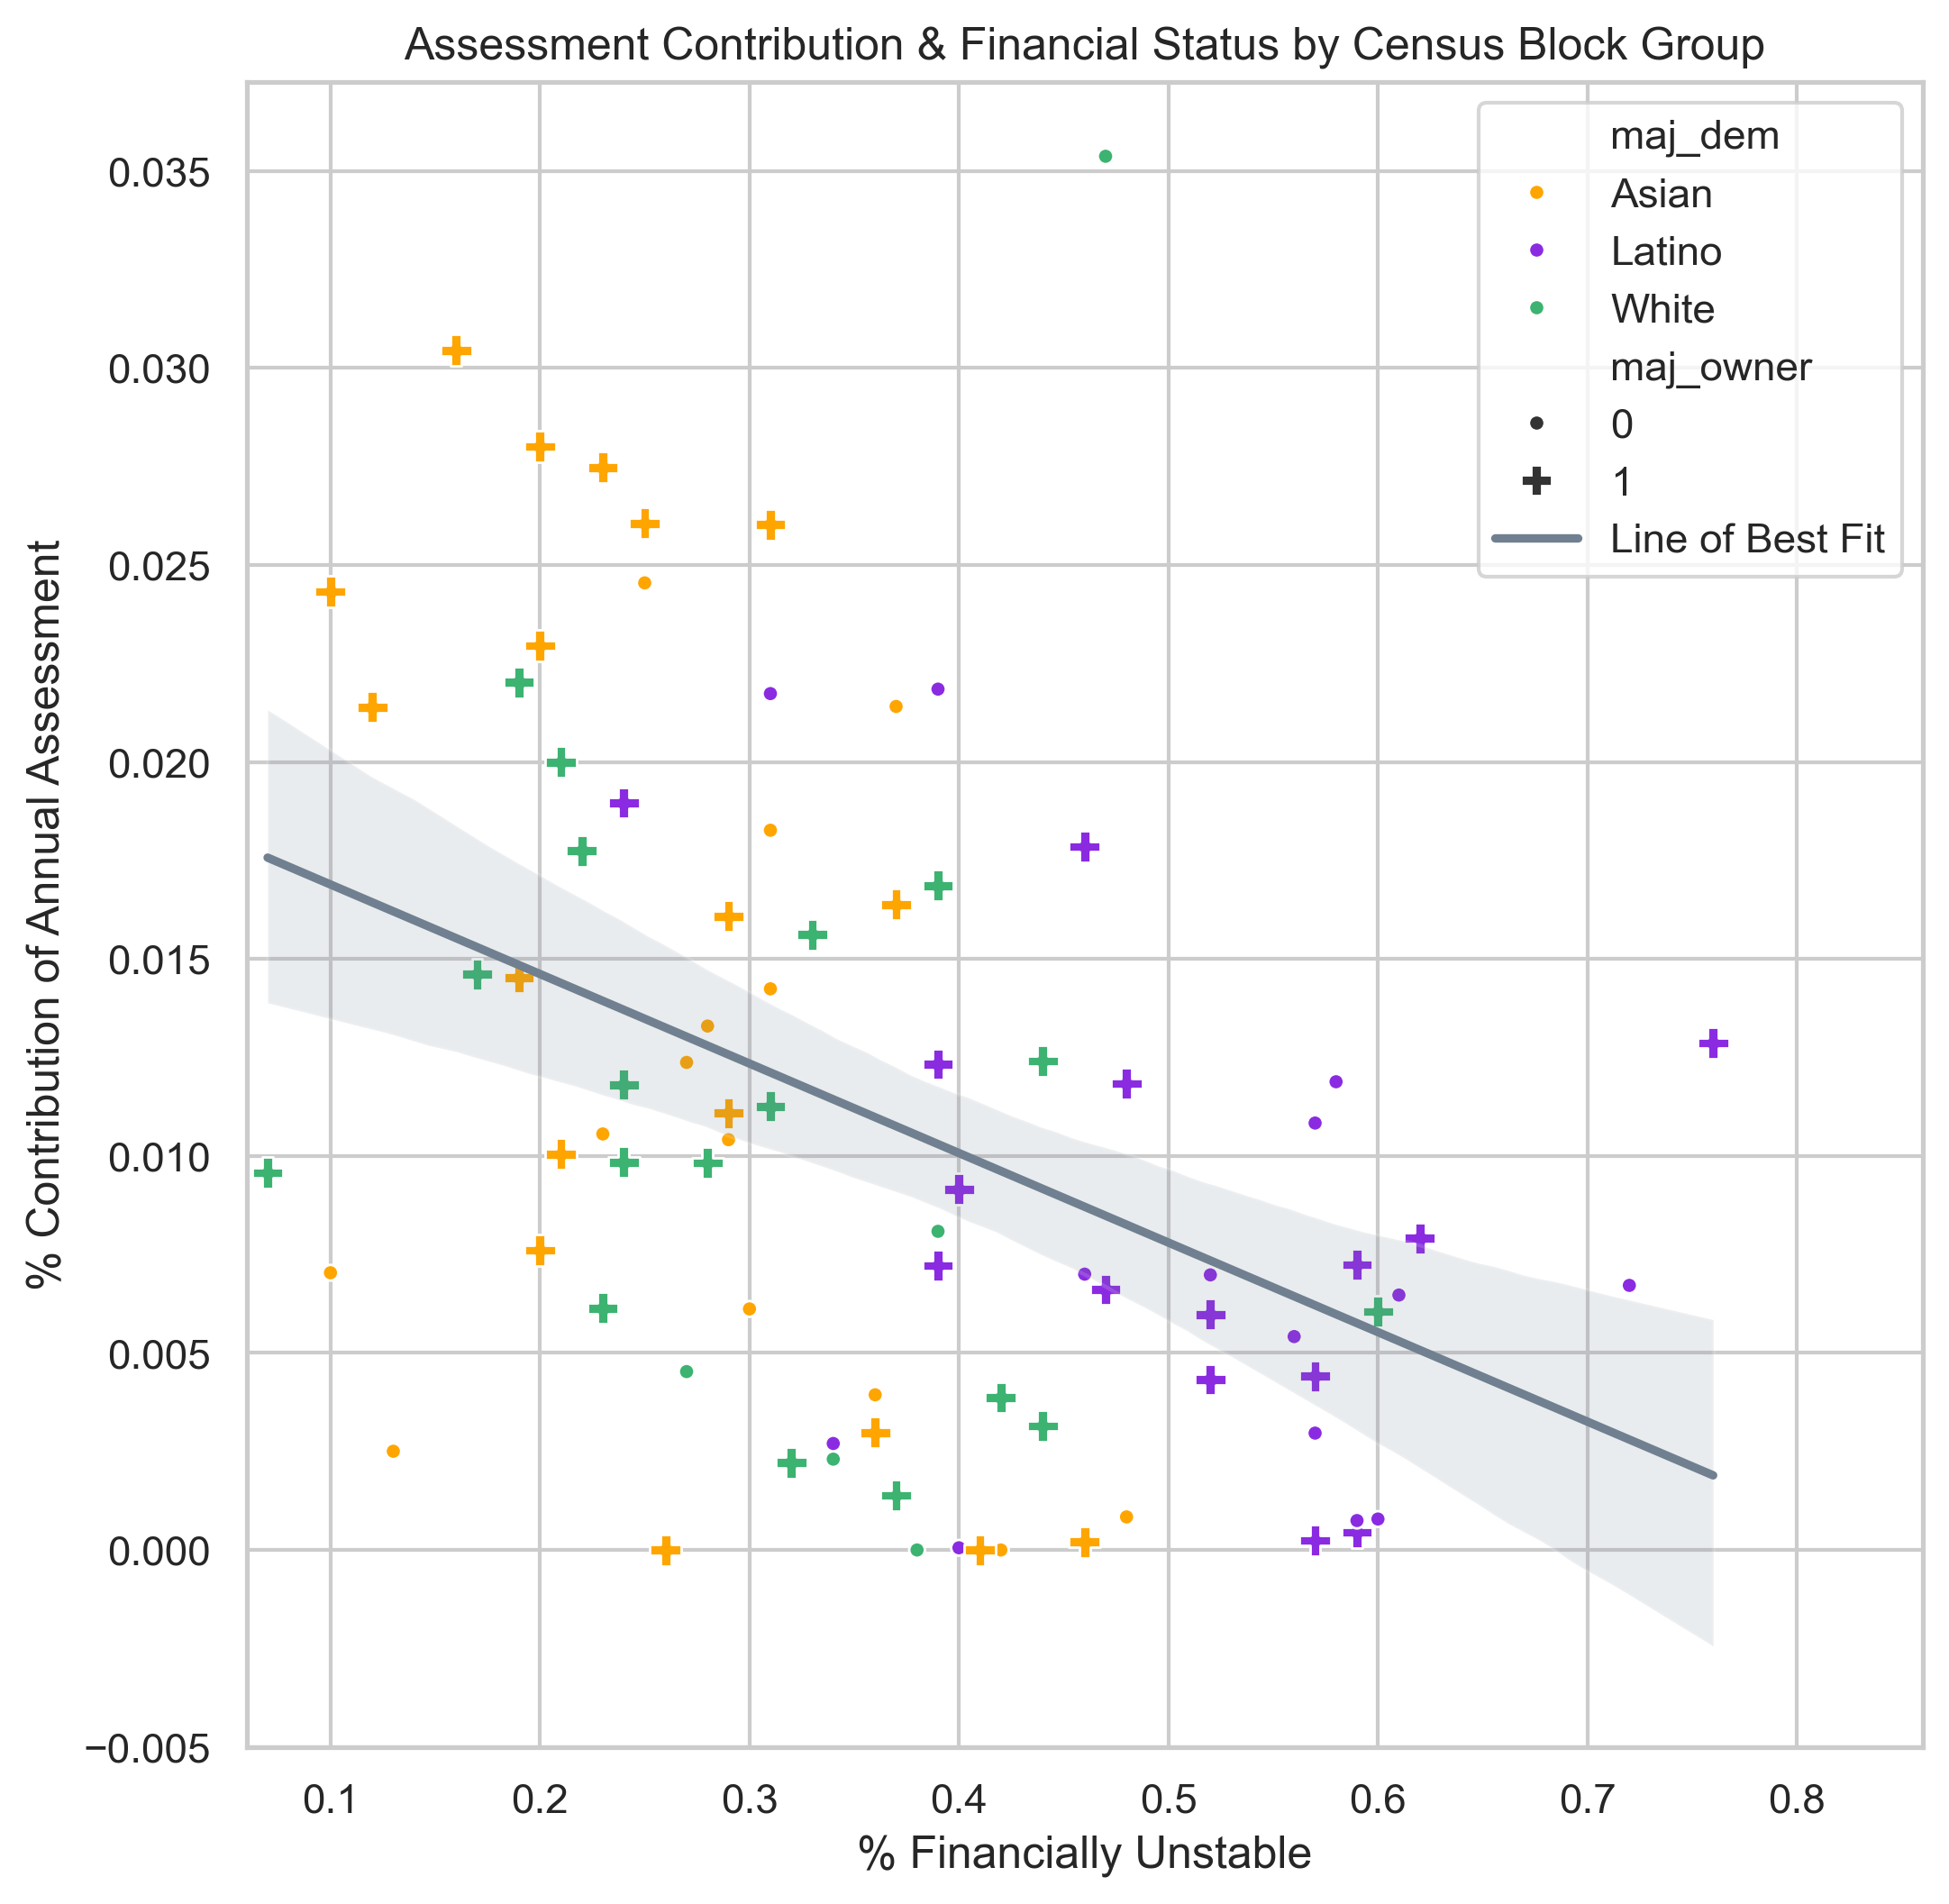

In [178]:

fig, ax = plt.subplots(figsize=(8, 8),dpi=300)

marker_types = {0: '.', 1: 'P'}
colors = {'White': 'mediumseagreen', 'Asian': 'orange', 'Latino': 'blueviolet'}
ax = plt.gca()

# Plot the data using Seaborn scatterplot
sns.scatterplot(data=smc, x="pct_finuns", y="annual_assessment_Residential_proportion",
                hue="maj_dem", style="maj_owner", palette=colors, markers=marker_types, ax=ax, s=70)
sns.regplot(data=smc, x="pct_finuns", y="annual_assessment_Residential_proportion", ax=ax, marker='+', scatter=False, line_kws={"color": "slategray"}, label='Line of Best Fit')
ax.set_title('Assessment Contribution & Financial Status by Census Block Group')
ax.set_xlabel('% Financially Unstable')
ax.set_ylabel('% Contribution of Annual Assessment')
plt.xlim(xmin=0.06, xmax=0.86)
plt.ylim(ymin=-0.005)
plt.legend()

#plt.legend(*sc.legend_elements("sizes", num=6))
plt.show()

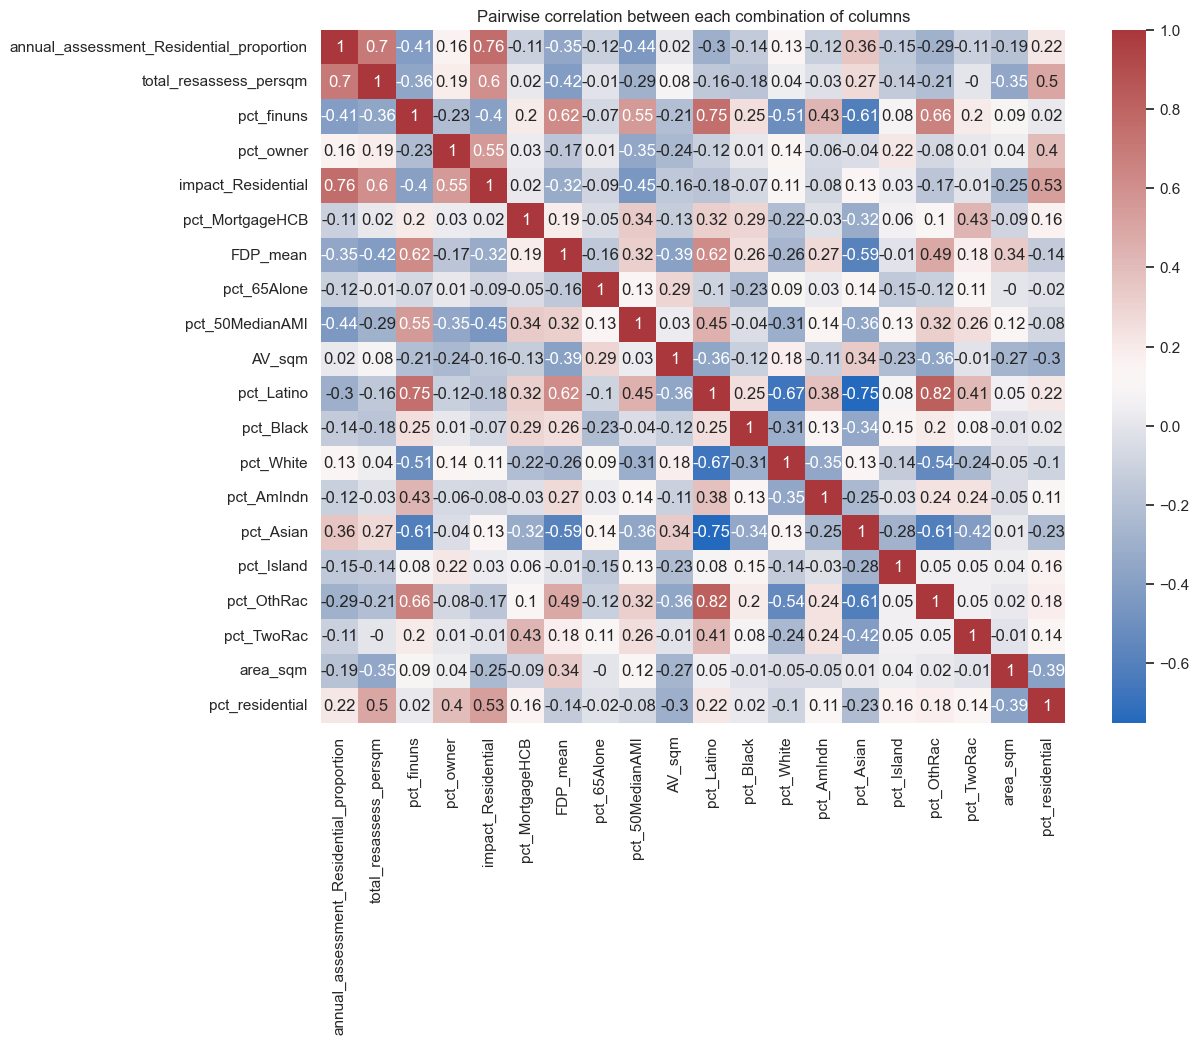

In [179]:
#Test for Multicolinearity by producing a Heat Map
sns.heatmap(smc[['annual_assessment_Residential_proportion','total_resassess_persqm','pct_finuns','pct_owner','impact_Residential','pct_MortgageHCB','FDP_mean',
                 'pct_65Alone','pct_50MedianAMI', 'AV_sqm', 'pct_Latino', 'pct_Black', 'pct_White', 'pct_AmIndn', 
                 'pct_Asian', 'pct_Island','pct_OthRac','pct_TwoRac', 'area_sqm','pct_residential']].corr().round(2), 
            annot=True,
            cmap='vlag')
plt.title('Pairwise correlation between each combination of columns');

In [180]:
#Save all features for easier calling
features = ['annual_assessment_Residential_proportion','total_resassess_persqm','pct_finuns','pct_owner','impact_Residential','pct_MortgageHCB','FDP_mean',
                 'pct_65Alone','pct_50MedianAMI', 'AV_sqm', 'pct_Latino', 'pct_Black', 'pct_White', 'pct_AmIndn', 
                 'pct_Asian', 'pct_Island','pct_OthRac','pct_TwoRac']

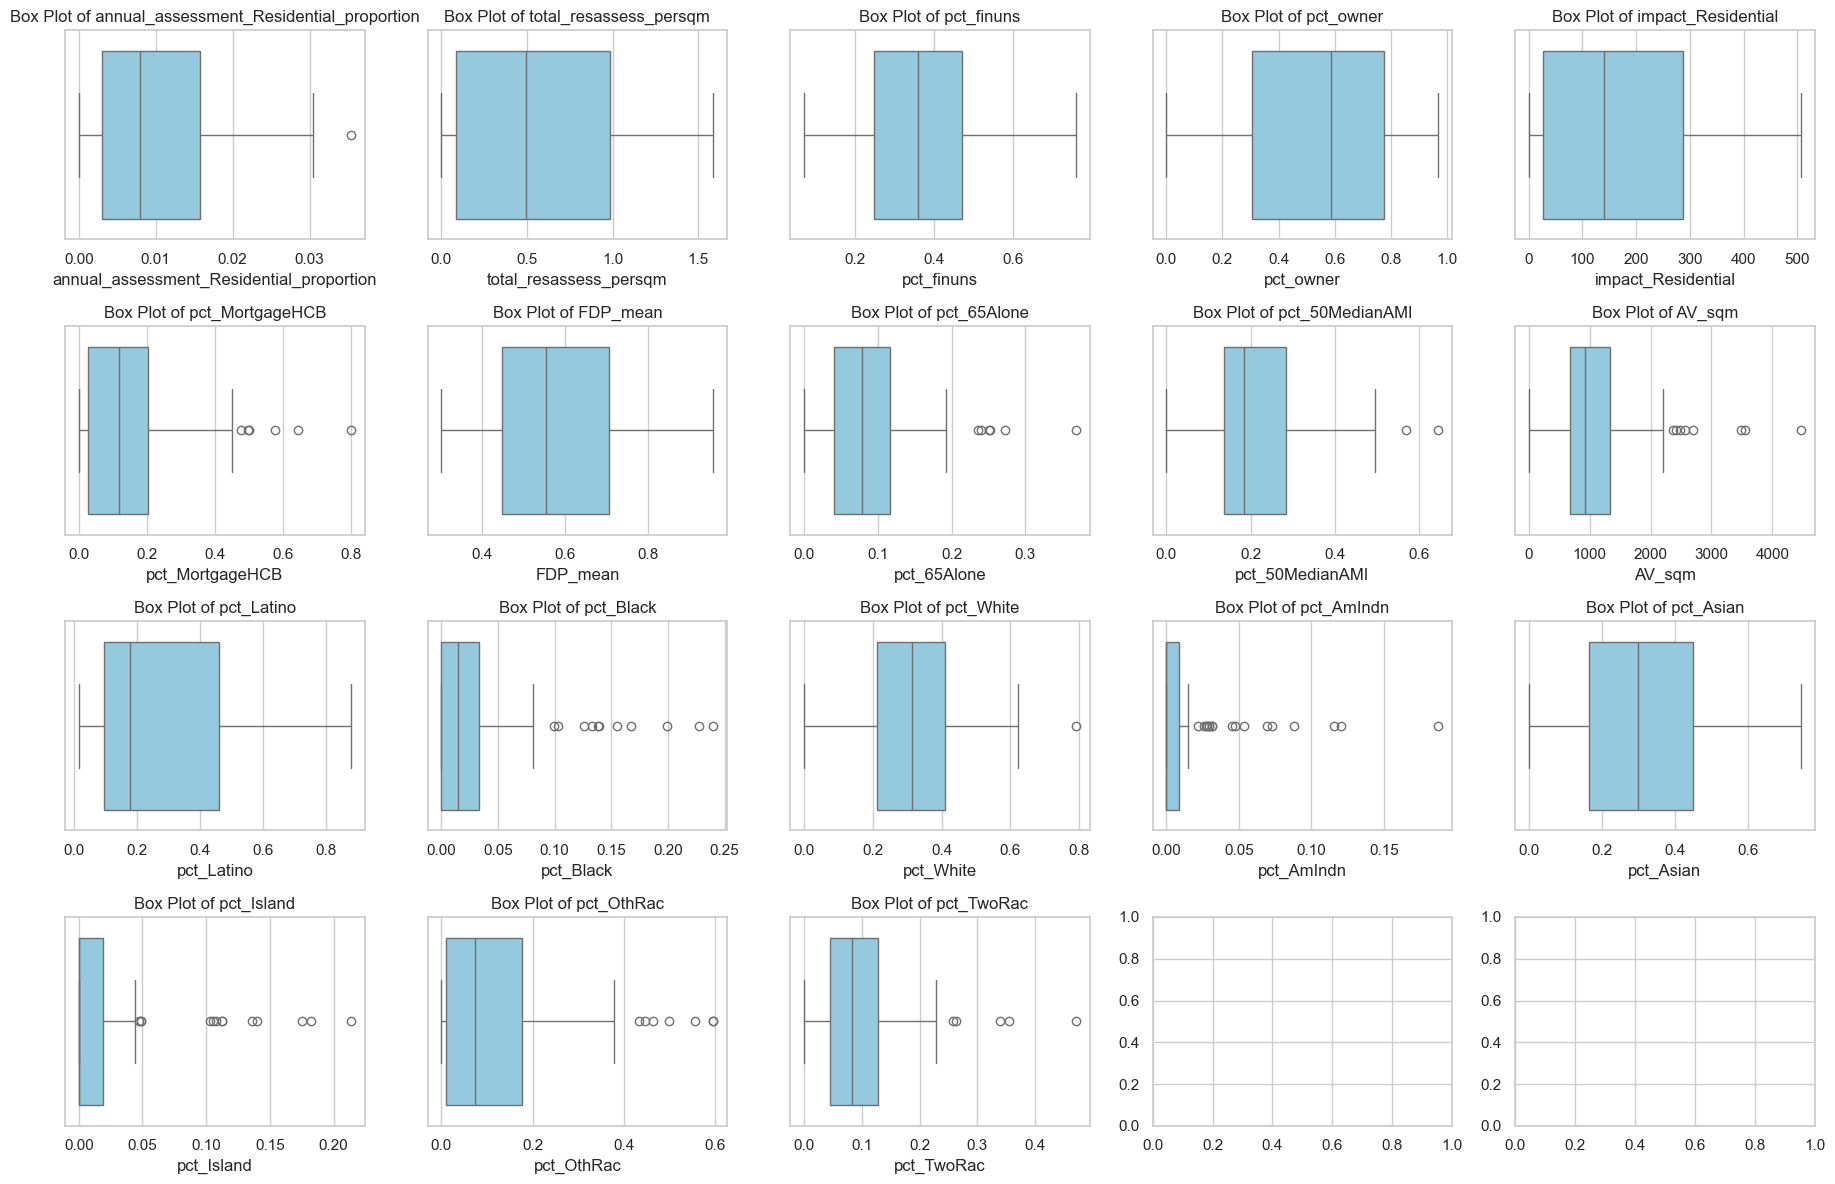

In [181]:
#BOXPLOTS OF ALL FEATURES
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(18, 12))
axes = axes.flatten()
for i, column in enumerate(smc[features].columns):
    sns.boxplot(x=smc[column], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Box Plot of {column}')

plt.tight_layout()
plt.show()

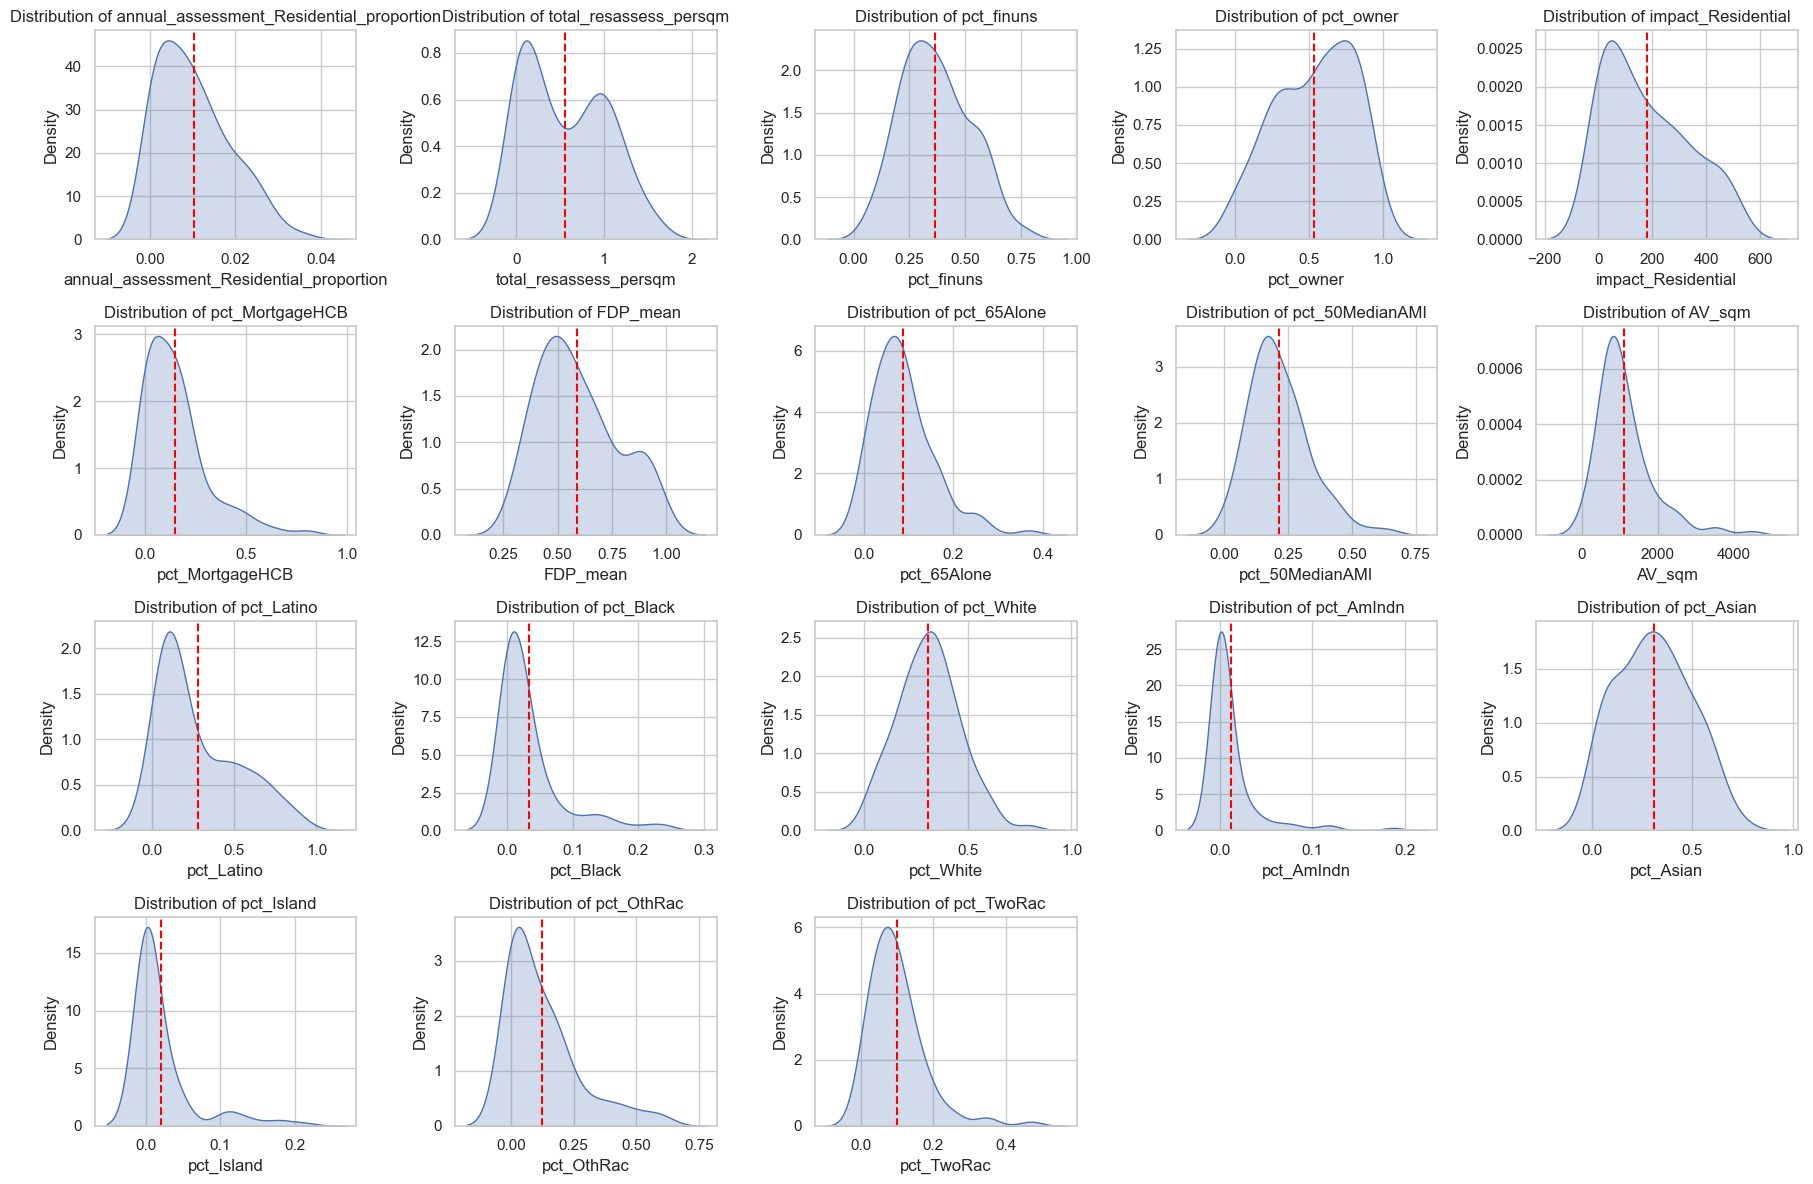

In [182]:
#KDES OF ALL FEATURES
sns.set(style="whitegrid")
fig = plt.figure(figsize=(18, 12))
for i, column in enumerate(smc[features].columns, 1):
    ax = fig.add_subplot(4, 5, i)
    sns.kdeplot(smc[column], ax=ax, fill=True)
    mean_value = smc[column].mean()
    ax.axvline(x=mean_value, color='red', linestyle='--', label=f'Mean Value')
    ax.set_title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

## OLS Regression

In [183]:
#Final Features Tested
testing_features = [
#    'pct_finuns_fill',
    'pct_owner',
#    'impact_Residential',
#    'pct_MortgageHCB',
#    'FDP_mean',
    'pct_65Alone',
    'pct_50MedianAMI', 
#    'AV_sqm',
    'area_sqm',
#   'pct_blackhisp',
    'pct_Latino', 
    'pct_Black', 
    'pct_White', 
    'pct_Asian',
#    'pct_residential',
]
# 'pct_AmIndn', 'pct_Island', 'pct_OthRac', 'pct_TwoRac'

# Create train/test sets
X = smc[testing_features]
Y = smc[["annual_assessment_Residential_proportion"]]
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=42, shuffle=True
)


# Fit the linear model and make predictions (you will need multiple lines)
model = lm.LinearRegression()
model.fit(X_train, Y_train)

# Compute RMSE on train and test sets
from sklearn.metrics import mean_squared_error

train_rmse_cpc = mean_squared_error(Y_train, model.predict(X_train), squared=False)
test_rmse_cpc = mean_squared_error(Y_test, model.predict(X_test), squared=False)

train_rmse_cpc, test_rmse_cpc

(0.006932912048640386, 0.008174336869103236)

In [184]:
# Use Stats Model to see OLS Regression Perfomance
sm.OLS(Y_train, X_train).fit(cov_type='HC0').summary2()

/Users/emmalina/opt/anaconda3/envs/cp255/lib/python3.9/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 7
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                    Results: Ordinary least squares
========================================================================================================
Model:                  OLS                                      Adj. R-squared (uncentered): 0.654     
Dependent Variable:     annual_assessment_Residential_proportion AIC:                         -444.4525 
Date:                   2024-05-03 15:49                         BIC:                         -427.0574 
No. Observations:       65                                       Log-Likelihood:              230.23    
Df Model:               8                                        F-statistic:                 21.44     
Df Residuals:           57                                       Prob (F-statistic):          7.52e-14  
R-squared (uncentered): 0.697                                    Scale:                       5.5985e-05
----------------------------------------------------------------------------------------------------------------
                          Coef.          Std.Err.            z            P>|z|           [0.025          0.975]
----------------------------------------------------------------------------------------------------------------
pct_owner                 0.0033           0.0041          0.7912         0.4288         -0.0048          0.0114
pct_65Alone              -0.0225           0.0106         -2.1241         0.0337         -0.0432         -0.0017
pct_50MedianAMI          -0.0234           0.0091         -2.5800         0.0099         -0.0412         -0.0056
area_sqm                 -0.0000           0.0000         -2.2316         0.0256         -0.0000         -0.0000
pct_Latino                0.0149           0.0056          2.6540         0.0080          0.0039          0.0259
pct_Black                -0.0176           0.0155         -1.1350         0.2564         -0.0481          0.0128
pct_White                 0.0218           0.0077          2.8122         0.0049          0.0066          0.0370
pct_Asian                 0.0181           0.0054          3.3456         0.0008          0.0075          0.0287
--------------------------------------------------------------------------------------------------------
Omnibus:                          5.042                    Durbin-Watson:                       2.231   
Prob(Omnibus):                    0.080                    Jarque-Bera (JB):                    4.105   
Skew:                             0.548                    Prob(JB):                            0.128   
Kurtosis:                         3.562                    Condition No.:                       78935039
========================================================================================================
Notes:
[1] R² is computed without centering (uncentered) since the                 model does not contain a
constant.
[2] Standard Errors are heteroscedasticity robust (HC0)
[3] The condition number is large, 7.89e+07. This might indicate                that there are strong
multicollinearity or other numerical                problems.
"""

### Standardize Variables

In [185]:
#Next, we standardize our features
all_features = [
    'annual_assessment_Residential_proportion','total_resassess_persqm',
    'pct_finuns_fill',
    'pct_owner',
    'impact_Residential',
    'pct_MortgageHCB',
    'FDP_mean',
    'pct_65Alone',
    'pct_50MedianAMI', 
    'TOT_VALUE',
    'area_sqm',
    'pct_blackhisp',
    'pct_Latino', 
    'pct_Black', 
    'pct_White', 
    'pct_Asian',
    'pct_AmIndn', 'pct_Island', 'pct_OthRac', 'pct_TwoRac',
    'pct_residential'
    #'displc_Exclusion','displc_Displacement','displc_No Loss',

]


In [186]:
#We import a package and build a function that creates a new standardized column for a list of features we pass in and appends to the dataframe
from sklearn.preprocessing import StandardScaler

def standardize_columns(df, columns_to_standardize):
    scaler = StandardScaler()
    df_standardized = df.copy()

    for column in columns_to_standardize:
        if column in df.columns:
            # Extract the column values, reshape for StandardScaler, and standardize
            column_values = df[column].values.reshape(-1, 1)
            standardized_values = scaler.fit_transform(column_values)

            # Create a new column with standardized values
            new_column_name = f"{column}_standardized"
            df_standardized[new_column_name] = standardized_values.flatten()
        else:
            print(f"Warning: Column '{column}' not found in the DataFrame.")

    return df_standardized

#Run the function
smc = standardize_columns(smc, all_features)
smc.head()

,OBJECTID,GEOID,NAME,TRACTID,socVuln70,socVuln90,ind_70pct,ind_90pct,socVulnRank,estimate_totPop,estimate_totHH,estimate_AveHHSize,estimate_renter,estimate_under5,estimate_noVeh,estimate_disabHH,estimate_SglPar,estimate_PoC,estimate_65Alone,estimate_noHS,estimate_MortgageHCB,estimate_LEP_HH,estimate_B200Pv,estimate_RentHCB,estimate_NoCtz,estimate_50MedianAMI,moe_totPop,moe_totHH,moe_AveHHSize,moe_renter,moe_under5,moe_noVeh,moe_disabHH,moe_SglPar,moe_PoC,moe_65Alone,moe_noHS,moe_MortgageHCB,moe_LEP_HH,moe_B200Pv,moe_RentHCB,moe_NoCtz,moe_50MedianAMI,pct_renter,pct_under5,pct_noVeh,pct_disabHH,pct_SglPar,pct_PoC,pct_65Alone,pct_noHS,pct_MortgageHCB,pct_LEP_HH,pct_B200Pv,pct_RentHCB,pct_NoCtz,pct_50MedianAMI,pct_moe_renter,pct_moe_under5,pct_moe_noVeh,pct_moe_disabHH,pct_moe_SglPar,pct_moe_PoC,pct_moe_65Alone,pct_moe_noHS,pct_moe_MortgageHCB,pct_moe_LEP_HH,pct_moe_B200Pv,pct_moe_RentHCB,pct_moe_NoCtz,pct_moe_50MedianAMI,flag70_renter,flag70_under5,flag70_noVeh,flag70_disabHH,flag70_SglPar,flag70_PoC,flag70_65Alone,flag70_noHS,flag70_LEP_HH,flag70_NoCtz,flag70_HCB,flag70_VLowInc,flag90_renter,flag90_under5,flag90_noVeh,flag90_disabHH,flag90_SglPar,flag90_PoC,flag90_65Alone,flag90_noHS,flag90_LEP_HH,flag90_NoCtz,flag90_HCB,flag90_VLowInc,estimate_ForBrn,estimate_LEP_Spanish,estimate_LEP_Chinese,estimate_LEP_Vietnms,estimate_LEP_Tagalog,moe_ForBrn,moe_LEP_Spanish,moe_LEP_Chinese,moe_LEP_Vietnms,moe_LEP_Tagalog,pct_ForBrn,pct_LEP_Spanish,pct_LEP_Chinese,pct_LEP_Vietnms,pct_LEP_Tagalog,pct_moe_ForBrn,pct_moe_LEP_Spanish,pct_moe_LEP_Chinese,pct_moe_LEP_Vietnms,pct_moe_LEP_Tagalog,estimate_Latino,estimate_Black,estimate_AmIndn,estimate_Asian,estimate_Island,estimate_OthRac,estimate_TwoRac,estimate_Under10,estimate_Under18,moe_Latino,moe_Black,moe_AmIndn,moe_Asian,moe_Island,moe_OthRac,moe_TwoRac,moe_Under10,moe_Under18,pct_Latino,pct_Black,pct_AmIndn,pct_Asian,pct_Island,pct_OthRac,pct_TwoRac,pct_Under10,pct_Under18,pct_moe_Latino,pct_moe_Black,pct_moe_AmIndn,pct_moe_Asian,pct_moe_Island,pct_moe_OthRac,pct_moe_TwoRac,pct_moe_Under10,pct_moe_Under18,MTC_CoC_2018,displcType,CES4_pctl,Clean_pctl,GW_pctl,Haz_pct,IWB_pctl,Solid_pctl,PDA_Name,PDA_ID,contam70,contam90,contamVulnRank,contam_ind_70pct,contam_ind_90pct,centroid_lng,centroid_lat,SUM_res_units_2010_exp_12,SUM_res_units_2040_exp_12,SUM_job_spaces_2010_exp_12,SUM_job_spaces_2040_exp_12,SUM_res_units_2010_exp_24,SUM_res_units_2040_exp_24,SUM_job_spaces_2010_exp_24,SUM_job_spaces_2040_exp_24,SUM_res_units_2010_exp_36,SUM_res_units_2040_exp_36,SUM_job_spaces_2010_exp_36,SUM_job_spaces_2040_exp_36,SUM_res_units_2010_exp_48,SUM_res_units_2040_exp_48,SUM_job_spaces_2010_exp_48,SUM_job_spaces_2040_exp_48,SUM_res_units_2010_exp_52,SUM_res_units_2040_exp_52,SUM_job_spaces_2010_exp_52,SUM_job_spaces_2040_exp_52,SUM_res_units_2010_exp_66,SUM_res_units_2040_exp_66,SUM_job_spaces_2010_exp_66,SUM_job_spaces_2040_exp_66,SUM_res_units_2010_exp_77,SUM_res_units_2040_exp_77,SUM_job_spaces_2010_exp_77,SUM_job_spaces_2040_exp_77,SUM_res_units_2010_exp_84,SUM_res_units_2040_exp_84,SUM_job_spaces_2010_exp_84,SUM_job_spaces_2040_exp_84,SUM_res_units_2010_exp_96,SUM_res_units_2040_exp_96,SUM_job_spaces_2010_exp_96,SUM_job_spaces_2040_exp_96,SUM_res_units_2010_exp_108,SUM_res_units_2040_exp_108,SUM_job_spaces_2010_exp_108,SUM_job_spaces_2040_exp_108,SUM_res_units_2010_exp_FEMA100,SUM_res_units_2040_exp_FEMA100,SUM_job_spaces_2010_exp_FEMA100,SUM_job_spaces_2040_exp_FEMA100,SUM_res_units_2010_exp_FEMA500,SUM_res_units_2040_exp_FEMA500,SUM_job_spaces_2010_exp_FEMA500,SUM_job_spaces_2040_exp_FEMA500,SUM_res_units_2010_exp_SFPrecip,SUM_res_units_2040_exp_SFPrecip,SUM_job_spaces_2010_exp_SFPreci,SUM_job_spaces_2040_exp_SFPreci,SUM_total_residential_units_201,SUM_total_residential_units_204,SUM_total_job_spaces_2010_Total,SUM_total_job_spaces_2040_Total,socVulnRank2020,contamVulnRank2020,soc_diff_val,contam_diff_val,combined_vulnerability,Shape__Area,Shape__Length,SHAPE,FDP_mean,LAND_VALUE,IMPR_VALUE,TOT_VALUE,LO

In [187]:
#Our final list of standardized features

standardized_features = [
 #   'pct_finuns_fill_standardized',
    'pct_owner_standardized',
#    'impact_Residential_standardized',
#    'pct_MortgageHCB_standardized',
#    'FDP_mean_standardized',
    'area_sqm_standardized',
    'pct_65Alone_standardized',
    'pct_50MedianAMI_standardized', 
#    'TOT_VALUE_standardized',
    #'pct_blackhisp_standardized',
    'pct_Latino_standardized', 
    'pct_Black_standardized', 
    'pct_White_standardized', 
    'pct_Asian_standardized',
#     'displc_Exclusion_standardized',
#     'displc_Displacement_standardized',
#     'displc_No Loss_standardized',
 #   'pct_residential_standardized'
]



In [188]:

# Create train/test sets
X = smc[standardized_features]
Y = smc[['annual_assessment_Residential_proportion_standardized']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.33,
                                                    random_state=42,
                                                    shuffle=True)


# Fit the linear model and make predictions (you will need multiple lines)
final_model = lm.LinearRegression()
final_model.fit(X_train, Y_train)

#Predictions
Y_predict_train = final_model.predict(X_train)
Y_predict_test = final_model.predict(X_test)

# Compute RMSE on train and test sets
train_rmse = mean_squared_error(Y_train, final_model.predict(X_train), squared=False)
test_rmse = mean_squared_error(Y_test, final_model.predict(X_test), squared=False)

train_rmse, test_rmse

(0.8250781268328322, 0.9728187094714866)

In [189]:
smc['annual_assessment_Residential_proportion_standardized'].describe()

count    9.800000e+01
mean     9.063045e-18
std      1.005141e+00
min     -1.214055e+00
25%     -8.606607e-01
50%     -2.622636e-01
75%      6.609731e-01
max      2.995240e+00
Name: annual_assessment_Residential_proportion_standardized, dtype: float64

In [190]:
#OLS regression outputs on standardized variables
sm.OLS(Y_train, X_train).fit(cov_type="HC0").summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                          Results: Ordinary least squares
===================================================================================================================
Model:                  OLS                                                   Adj. R-squared (uncentered): 0.245   
Dependent Variable:     annual_assessment_Residential_proportion_standardized AIC:                         175.5729
Date:                   2024-05-03 15:49                                      BIC:                         192.9680
No. Observations:       65                                                    Log-Likelihood:              -79.786 
Df Model:               8                                                     F-statistic:                 5.627   
Df Residuals:           57                                                    Prob (F-statistic):          2.89e-05
R-squared (uncentered): 0.338                                                 Scale:                       0.77758 
--------------------------------------------------------------------------------------------------------------------------
                                         Coef.         Std.Err.           z           P>|z|          [0.025         0.975]
--------------------------------------------------------------------------------------------------------------------------
pct_owner_standardized                   0.1447          0.1390         1.0410        0.2979        -0.1278         0.4172
area_sqm_standardized                   -0.1716          0.0665        -2.5813        0.0098        -0.3020        -0.0413
pct_65Alone_standardized                -0.1864          0.0830        -2.2454        0.0247        -0.3491        -0.0237
pct_50MedianAMI_standardized            -0.2995          0.1275        -2.3488        0.0188        -0.5494        -0.0496
pct_Latino_standardized                  0.9234          0.3615         2.5545        0.0106         0.2149         1.6319
pct_Black_standardized                   0.0094          0.1194         0.0791        0.9370        -0.2245         0.2434
pct_White_standardized                   0.7335          0.2747         2.6700        0.0076         0.1950         1.2719
pct_Asian_standardized                   0.7877          0.2923         2.6945        0.0070         0.2147         1.3607
-------------------------------------------------------------------------------------------------------------------
Omnibus:                                5.658                        Durbin-Watson:                           2.278
Prob(Omnibus):                          0.059                        Jarque-Bera (JB):                        4.872
Skew:                                   0.521                        Prob(JB):                                0.087
Kurtosis:                               3.846                        Condition No.:                           10   
===================================================================================================================
Notes:
[1] R² is computed without centering (uncentered) since the                 model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC0)
"""

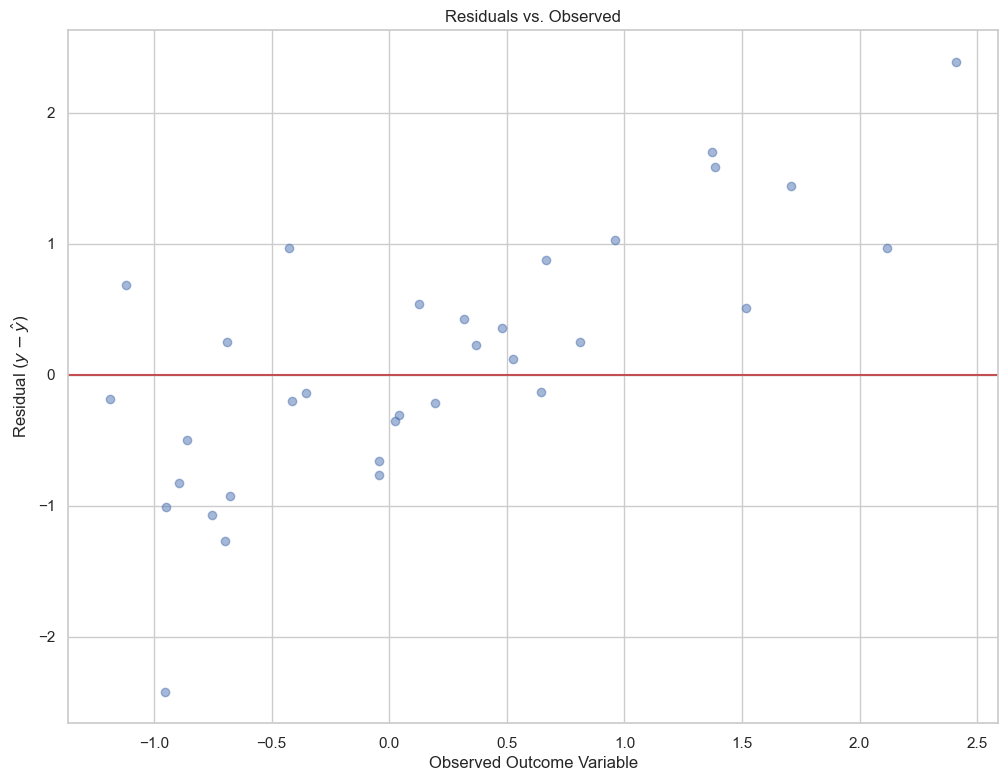

In [191]:
#Looking at performance of test data here
plt.scatter(Y_test, Y_test - final_model.predict(X_test), alpha=0.5)
plt.ylabel("Residual $(y - \hat{y})$")
plt.xlabel("Observed Outcome Variable")
plt.title("Residuals vs. Observed")
plt.axhline(y = 0, color='r');

In [192]:
#Print a table of final standardized coefficients
final_coef = pd.DataFrame({"Feature":X_train.columns.to_numpy(), "Coef":final_model.coef_[0]})
final_coef

,Feature,Coef
0,pct_owner_standardized,0.146059
1,area_sqm_standardized,-0.170272
2,pct_65Alone_standardized,-0.184519
3,pct_50MedianAMI_standardized,-0.294660
4,pct_Latino_standardized,0.925011
5,pct_Black_standardized,0.010280
6,pct_White_standardized,0.737267
7,pct_Asian_standardized,0.788885


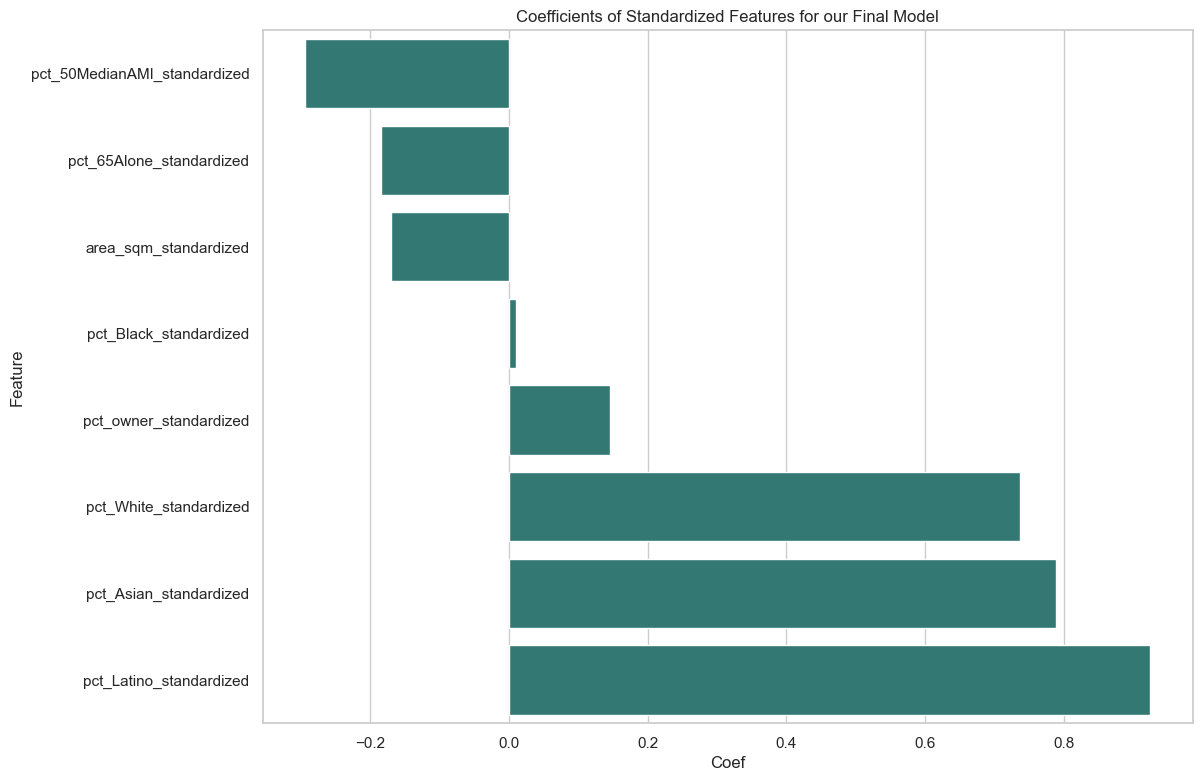

In [193]:
#Plot coefficients in a graph
sns.barplot(data=final_coef.sort_values(by='Coef'), x="Coef", y='Feature', color='#28837d')
plt.title("Coefficients of Standardized Features for our Final Model")
plt.show()

### K-MEANS CLUSTERING

In [194]:
smc['pct_households'] = smc['estimate_totHH']/(smc['estimate_totHH'].sum())
smc['pct_totPop'] = smc['estimate_totPop']/(smc['estimate_totPop'].sum())

In [195]:
#final features used:

k_features = [
#    'impact_Residential',
    'pct_residential',    
    'FDP_mean',
'pct_owner',    
    'pct_Asian',
        'pct_White',
    'pct_MortgageHCB',
                'pct_Black', 
#    'pct_65Alone',
 #   'TOT_VALUE',
#    'area_sqm',
    #'pct_blackhisp',
#'pct_households',

            #'pct_50MedianAMI',
        'pct_finuns_fill',
    'pct_Latino',


#    'pct_AmIndn', 'pct_Island', 'pct_OthRac', 'pct_TwoRac'

]

In [196]:

# Separate outcome variable (y) from explanatory variables (X)
X = smc[k_features]
y = smc['annual_assessment_Residential_proportion']

# Step 2: Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: K-means Clustering

k = 3  # Choose the number of clusters


kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)
clusters = kmeans.predict(X_scaled)

# Step 4: Cluster Assignment
data_with_clusters = X.copy()
data_with_clusters['Cluster'] = clusters

# Step 5: Radial Plot Creation
# Calculate mean values of explanatory variables for each cluster
cluster_means = data_with_clusters.groupby('Cluster').mean()




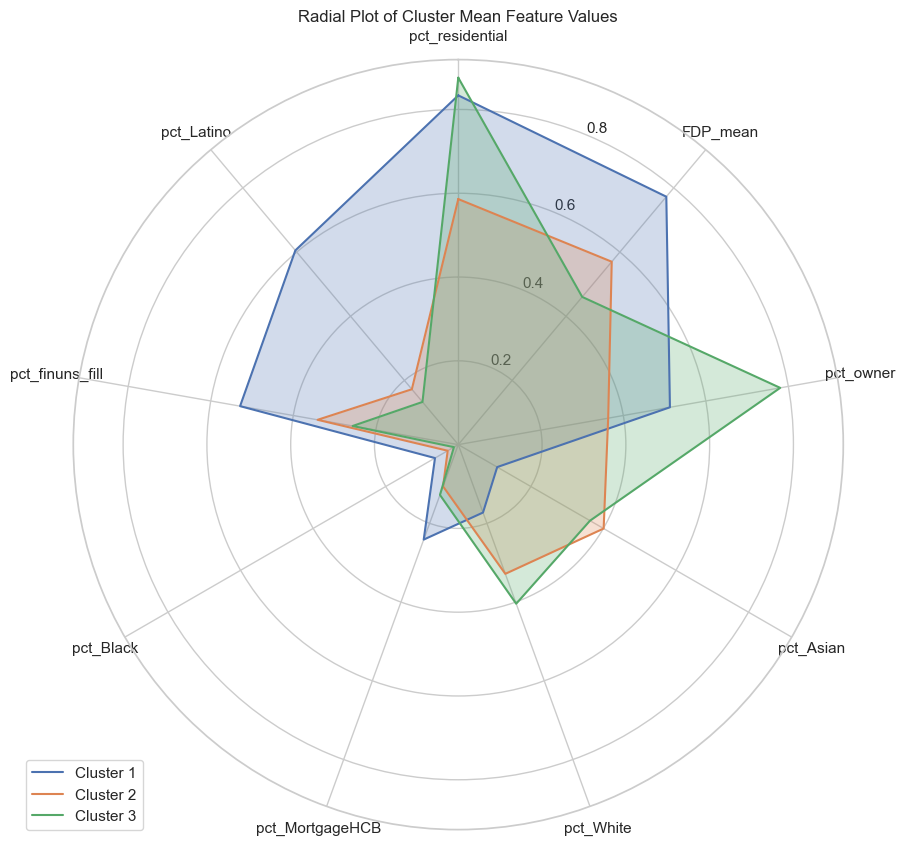

In [197]:
# Plot radial plot
num_clusters = len(cluster_means)
num_features = len(k_features)  # Use k_features instead of cluster_means.columns
angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
for i in range(num_clusters):
    values = cluster_means.iloc[i].values  # Select all values from the row
    values = np.concatenate((values, [values[0]]))  # Repeat the first value to close the plot
    angles_with_end = np.concatenate((angles, [angles[0]]))  # Repeat the first angle to close the plot
    cluster_number = i + 1  # Increment cluster number by 1
    ax.plot(angles_with_end, values, label=f'Cluster {cluster_number}')
    ax.fill(angles_with_end, values, alpha=0.25)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles, k_features)  # Use k_features for the x-axis labels
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Radial Plot of Cluster Mean Feature Values')
plt.show()


In [198]:
#table of mean values per cluster
cluster_means

,pct_residential,FDP_mean,pct_owner,pct_Asian,pct_White,pct_MortgageHCB,pct_Black,pct_finuns_fill,pct_Latino
Cluster,,,,,,,,,
0,0.833604,0.772509,0.513015,0.107263,0.172533,0.241260,0.064204,0.528889,0.605102
1,0.586052,0.569863,0.363329,0.400660,0.328261,0.106123,0.029213,0.341000,0.172479
2,0.875806,0.460193,0.780252,0.363107,0.404163,0.127847,0.012090,0.256129,0.132968


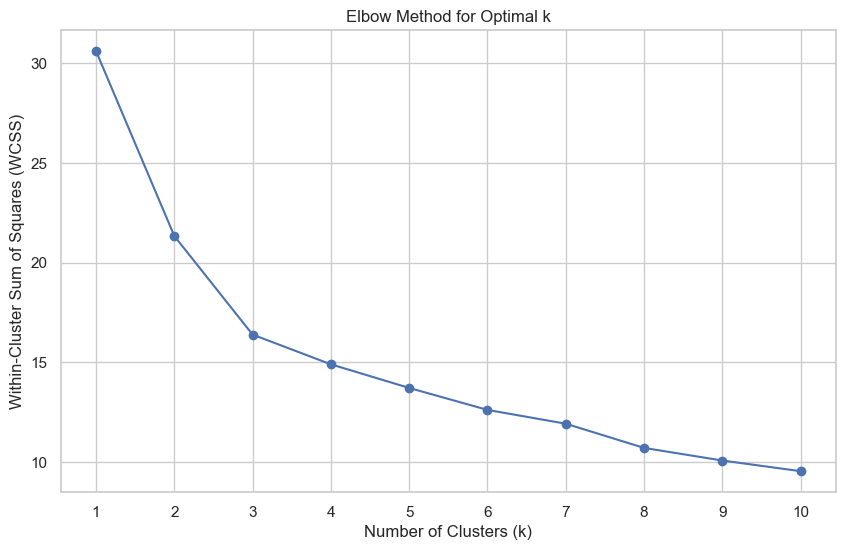

In [199]:
#confirm number of clusters with elbow method
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assuming X is your standardized data
wcss = []

# Try different values of k
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # Inertia is the within-cluster sum of squares

# Plot the elbow plot
plt.figure(figsize=(10,6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


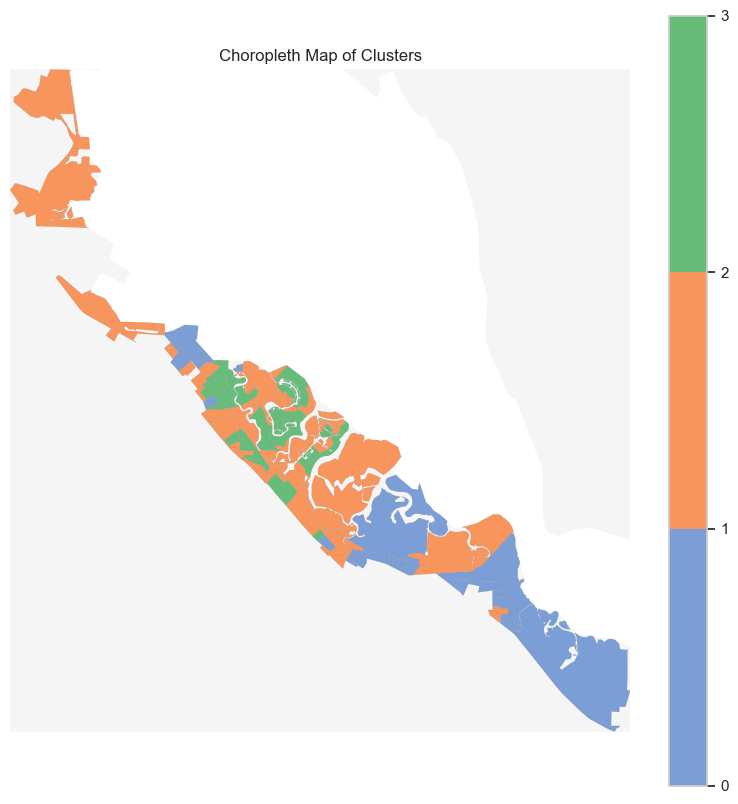

In [201]:
#plot cloropleth of clusters 

outlines = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_state_500k.zip')
outlines = outlines[outlines['GEOID'] == '06']  # just CA
outlines = outlines.to_crs(crs)

# Combine data_with_clusters with original geometry
data_with_clusters_geom = smc[['geometry']].join(data_with_clusters)

# Convert to GeoDataFrame
gdf_with_clusters = gpd.GeoDataFrame(data_with_clusters_geom)

import matplotlib.colors as mcolors

colors = ['#7B9ED7', '#F8955C', '#66BD79']

cmap = mcolors.ListedColormap(colors)

# Get the number of unique clusters
num_clusters = len(data_with_clusters['Cluster'].unique())

# Create a BoundaryNorm to map the cluster values to colormap indices
norm = mcolors.BoundaryNorm(boundaries=np.arange(num_clusters + 1), ncolors=num_clusters)

# Plot choropleth map using the custom colormap
fig, ax = plt.subplots(figsize=(10, 10))
outlines.plot(ax=ax, facecolor='none', color='whitesmoke',linewidth=0.3)
gdf_with_clusters.plot(column='Cluster', cmap=cmap, norm=norm, edgecolor="gray", linewidth=.1, ax=ax, legend=True)
ax.set_title('Choropleth Map of Clusters')
ax.axis('off')

minx, miny, maxx, maxy = gdf_with_clusters.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
plt.show()

